# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-lc'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.7887, F1 Micro: 0.0189, F1 Macro: 0.017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2695, Accuracy: 0.8423, F1 Micro: 0.4891, F1 Macro: 0.4083
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2149, Accuracy: 0.8652, F1 Micro: 0.6473, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.8725, F1 Micro: 0.6617, F1 Macro: 0.6453
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.872, F1 Micro: 0.6787, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.8736, F1 Micro: 0.6934, F1 Macro: 0.6808
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.8734, F1 Micro: 0.6911, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.86, F1 Micro: 0.7126

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.7952, F1 Micro: 0.094, F1 Macro: 0.0609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.8605, F1 Micro: 0.6185, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.8722, F1 Micro: 0.6723, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.8766, F1 Micro: 0.6832, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.87, F1 Micro: 0.7137, F1 Macro: 0.7118
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.875, F1 Micro: 0.7061, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.8769, F1 Micro: 0.7145, F1 Macro: 0.7084
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.8745, F1 Micro: 0.7005, F1 Macro: 0.691
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3208, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.7881, F1 Micro: 0.0259, F1 Macro: 0.0169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.8542, F1 Micro: 0.6467, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.8702, F1 Micro: 0.6868, F1 Macro: 0.6824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.8786, F1 Micro: 0.72, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.8817, F1 Micro: 0.7238, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.8864, F1 Micro: 0.7376, F1 Macro: 0.7341
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.8827, F1 Micro: 0.7332, F1 Macro: 0.732
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.8841, F1 Micro: 0.735, F1 Macro: 0.7335
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3002, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.8273, F1 Micro: 0.3939, F1 Macro: 0.2856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.8659, F1 Micro: 0.6692, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.8733, F1 Micro: 0.7171, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.8894, F1 Micro: 0.735, F1 Macro: 0.7197
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.8853, F1 Micro: 0.7261, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.8891, F1 Micro: 0.7357, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8755, F1 Micro: 0.7448, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8916, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.8438, F1 Micro: 0.484, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.8752, F1 Micro: 0.7123, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.8658, F1 Micro: 0.7269, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.893, F1 Micro: 0.7512, F1 Macro: 0.7499
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.8858, F1 Micro: 0.7489, F1 Macro: 0.7447
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.8891, F1 Micro: 0.7473, F1 Macro: 0.7418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8914, F1 Micro: 0.7593, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.8936, F1 Micro: 0.7598, F1 Macro: 0.7597
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3392, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8664, F1 Micro: 0.6708, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.8758, F1 Micro: 0.6743, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.8923, F1 Micro: 0.7484, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.882, F1 Micro: 0.753, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.8913, F1 Micro: 0.7645, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.887, F1 Micro: 0.7629, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.8923, F1 Micro: 0.7698, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8913, F1 Micro: 0.7628, F1 Macro: 0.7608
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.7911, F1 Micro: 0.0551, F1 Macro: 0.0364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.877, F1 Micro: 0.6773, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.8869, F1 Micro: 0.7023, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.8942, F1 Micro: 0.7676, F1 Macro: 0.765
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.8881, F1 Micro: 0.7646, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.8964, F1 Micro: 0.7735, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.895, F1 Micro: 0.7695, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.8975, F1 Micro: 0.7709, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.8956, F1 Micro: 0.7653, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.8945, F1 Micro: 0.7639, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8002, F1 Micro: 0.189, F1 Macro: 0.1646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.8877, F1 Micro: 0.7375, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.8955, F1 Micro: 0.755, F1 Macro: 0.7499
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.8953, F1 Micro: 0.7294, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.8939, F1 Micro: 0.7722, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9011, F1 Micro: 0.7677, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.8991, F1 Micro: 0.773, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.8975, F1 Micro: 0.7743, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.8984, F1 Micro: 0.768, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0323, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8316, F1 Micro: 0.4192, F1 Macro: 0.3785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.8872, F1 Micro: 0.7275, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8944, F1 Micro: 0.7625, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.8955, F1 Micro: 0.7702, F1 Macro: 0.7669
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.8988, F1 Micro: 0.7595, F1 Macro: 0.7511
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.8895, F1 Micro: 0.7625, F1 Macro: 0.7652
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9011, F1 Micro: 0.7616, F1 Macro: 0.7471
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.8953, F1 Micro: 0.7633, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8994, F1 Micro: 0.7726, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.8984, F1 Micro: 0.7716, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8258, F1 Micro: 0.383, F1 Macro: 0.3428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2821, Accuracy: 0.8911, F1 Micro: 0.7383, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8958, F1 Micro: 0.7516, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9016, F1 Micro: 0.7644, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9028, F1 Micro: 0.7684, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.8942, F1 Micro: 0.7729, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9014, F1 Micro: 0.7805, F1 Macro: 0.7795
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.8984, F1 Micro: 0.7652, F1 Macro: 0.7564
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7707
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8552, F1 Micro: 0.5662, F1 Macro: 0.5248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.8853, F1 Micro: 0.685, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.8948, F1 Micro: 0.7745, F1 Macro: 0.7773
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9, F1 Micro: 0.7785, F1 Macro: 0.7785
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9059, F1 Micro: 0.7833, F1 Macro: 0.782
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9038, F1 Micro: 0.771, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9019, F1 Micro: 0.7674, F1 Macro: 0.7614
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.8997, F1 Micro: 0.7775, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9066, F1 Micro: 0.7821, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.8686, F1 Micro: 0.6438, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.8919, F1 Micro: 0.7328, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.8994, F1 Micro: 0.7765, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9025, F1 Micro: 0.7818, F1 Macro: 0.7782
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9031, F1 Micro: 0.7811, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9039, F1 Micro: 0.7795, F1 Macro: 0.781
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9027, F1 Micro: 0.7799, F1 Macro: 0.7779
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.8997, F1 Micro: 0.7738, F1 Macro: 0.7736
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9047, F1 Micro: 0.7785, F1 Macro: 0.7778
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8995, F1 Micro: 0.7774, F1 Macro: 0.7768

 Iteration 4530: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.8709, F1 Micro: 0.6756, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.892, F1 Micro: 0.7631, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2181, Accuracy: 0.9019, F1 Micro: 0.777, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9039, F1 Micro: 0.7776, F1 Macro: 0.769
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9014, F1 Micro: 0.7713, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.8997, F1 Micro: 0.7579, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.8986, F1 Micro: 0.778, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9023, F1 Micro: 0.7715, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.8997, F1 Micro: 0.7669, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0348, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8628, F1 Micro: 0.6699, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8877, F1 Micro: 0.7622, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2153, Accuracy: 0.8992, F1 Micro: 0.7739, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9036, F1 Micro: 0.7803, F1 Macro: 0.7797
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9011, F1 Micro: 0.773, F1 Macro: 0.7697
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9069, F1 Micro: 0.7779, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9031, F1 Micro: 0.7801, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9013, F1 Micro: 0.7806, F1 Macro: 0.7811
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9006, F1 Micro: 0.7574, F1 Macro: 0.7481
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9022, F1 Micro: 0.7756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8764, F1 Micro: 0.6773, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.8948, F1 Micro: 0.7259, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9034, F1 Micro: 0.7634, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9042, F1 Micro: 0.7871, F1 Macro: 0.7834
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.8956, F1 Micro: 0.7775, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.8989, F1 Micro: 0.7662, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9086, F1 Micro: 0.785, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0561, Accuracy: 0.9073, F1 Micro: 0.7793, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.907, F1 Micro: 0.7919, F1 Macro: 0.7896
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9055, F1 Micro: 0.7848, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8838, F1 Micro: 0.7337, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9002, F1 Micro: 0.7679, F1 Macro: 0.7661
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8995, F1 Micro: 0.7433, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9016, F1 Micro: 0.7701, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9005, F1 Micro: 0.7821, F1 Macro: 0.7831
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.8995, F1 Micro: 0.7751, F1 Macro: 0.7784
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9039, F1 Micro: 0.78, F1 Macro: 0.7786
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9011, F1 Micro: 0.7684, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.8988, F1 Micro: 0.7681, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.9045, F1 Micro: 0.7688, F1 Macro: 0.7634

 Iteration 5263: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8841, F1 Micro: 0.7074, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9002, F1 Micro: 0.7652, F1 Macro: 0.7612
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.8995, F1 Micro: 0.7524, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9058, F1 Micro: 0.7724, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.8988, F1 Micro: 0.7745, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8973, F1 Micro: 0.7799, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.8997, F1 Micro: 0.7768, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.8986, F1 Micro: 0.7764, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9014, F1 Micro: 0.7643, F1 Macro: 0.7543
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9009, F1 Micro: 0.7732, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8864, F1 Micro: 0.7233, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9003, F1 Micro: 0.7765, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9041, F1 Micro: 0.7812, F1 Macro: 0.7797
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9036, F1 Micro: 0.7794, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.8978, F1 Micro: 0.7692, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9008, F1 Micro: 0.7725, F1 Macro: 0.773
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9023, F1 Micro: 0.7733, F1 Macro: 0.7707
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9017, F1 Micro: 0.777, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9013, F1 Micro: 0.7778, F1 Macro: 0.777
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9044, F1 Micro: 0.781, F1 Macro: 0.7798

 Iteration 5641: Accuracy: 0.9041, F1 Micro: 0.7812, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8866, F1 Micro: 0.7409, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.902, F1 Micro: 0.7737, F1 Macro: 0.7669
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9011, F1 Micro: 0.7557, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.8994, F1 Micro: 0.7744, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.8994, F1 Micro: 0.7715, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.8995, F1 Micro: 0.7821, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9033, F1 Micro: 0.7723, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.8978, F1 Micro: 0.774, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9, F1 Micro: 0.7716, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8991, F1 Micro: 0.7729, F1 Macro: 0.7693

 Iteration 5841: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8895, F1 Micro: 0.7527, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8986, F1 Micro: 0.7733, F1 Macro: 0.7709
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro: 0.7675
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9034, F1 Micro: 0.7668, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9056, F1 Micro: 0.7867, F1 Macro: 0.7837
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.8992, F1 Micro: 0.7849, F1 Macro: 0.7872
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9025, F1 Micro: 0.7842, F1 Macro: 0.783
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9055, F1 Micro: 0.7783, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9053, F1 Micro: 0.7764, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9077, F1 Micro: 0.7791, F1 Macro: 0.7739

 Iteration 6041: Accuracy: 0.9056, F1 Micro: 0.7867,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8891, F1 Micro: 0.7411, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9017, F1 Micro: 0.7762, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9048, F1 Micro: 0.7919, F1 Macro: 0.7903
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9056, F1 Micro: 0.7878, F1 Macro: 0.7868
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9023, F1 Micro: 0.763, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9081, F1 Micro: 0.7763, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9017, F1 Micro: 0.7795, F1 Macro: 0.775
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9023, F1 Micro: 0.7859, F1 Macro: 0.786
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9038, F1 Micro: 0.7781, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9016, F1 Micro: 0.7719, F1 Macro: 0.7649

 Iteration 6218: Accuracy: 0.9048, F1 Micro: 0.7919, F1

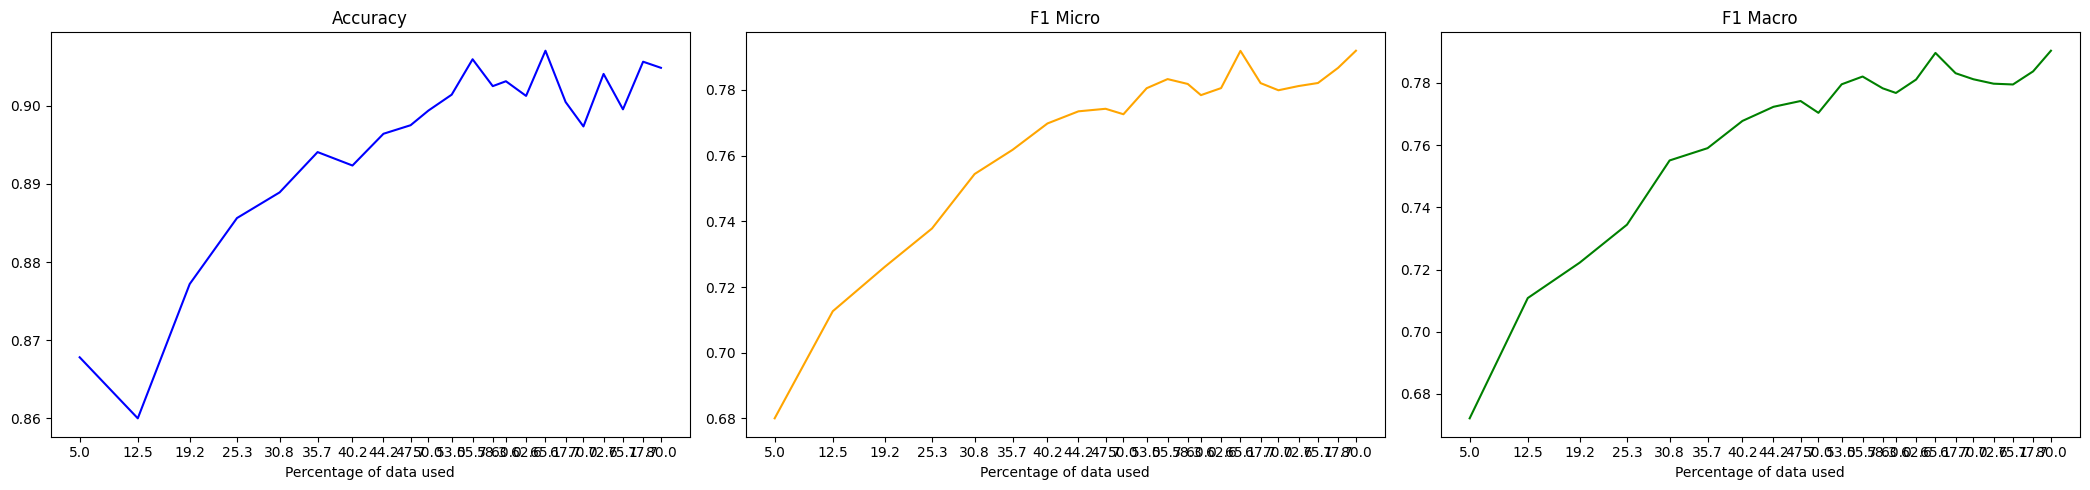

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.8147, F1 Micro: 0.2329, F1 Macro: 0.1737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2532, Accuracy: 0.833, F1 Micro: 0.3796, F1 Macro: 0.2582
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.215, Accuracy: 0.8558, F1 Micro: 0.6061, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.87, F1 Micro: 0.6763, F1 Macro: 0.6691
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.8611, F1 Micro: 0.5855, F1 Macro: 0.5237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.8733, F1 Micro: 0.7173, F1 Macro: 0.7158
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.8667, F1 Micro: 0.628, F1 Macro: 0.6021
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.8698, F1 Micro: 0.659, F1 Macro: 0.6388
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.8714,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3321, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2323, Accuracy: 0.8223, F1 Micro: 0.2942, F1 Macro: 0.2077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.8477, F1 Micro: 0.4987, F1 Macro: 0.3951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.8697, F1 Micro: 0.6454, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.875, F1 Micro: 0.7118, F1 Macro: 0.7023
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.8741, F1 Micro: 0.6924, F1 Macro: 0.6851
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.8714, F1 Micro: 0.6631, F1 Macro: 0.6615
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8775, F1 Micro: 0.6891, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.8725, F1 Micro: 0.672, F1 Macro: 0.6503
Epoch 10/10, Train Loss: 0.0286, Accuracy: 0.8741, F1 Micro: 0.7101, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.312, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.8259, F1 Micro: 0.3207, F1 Macro: 0.2226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.8647, F1 Micro: 0.6416, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.8709, F1 Micro: 0.7241, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.8741, F1 Micro: 0.6608, F1 Macro: 0.6079
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.8792, F1 Micro: 0.6965, F1 Macro: 0.6825
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.8734, F1 Micro: 0.6617, F1 Macro: 0.6449
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.8781, F1 Micro: 0.7214, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.8786, F1 Micro: 0.731, F1 Macro: 0.7325
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8834, F1 Micro: 0.7133, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.323, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.8366, F1 Micro: 0.4043, F1 Macro: 0.3054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.8722, F1 Micro: 0.6738, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.88, F1 Micro: 0.7119, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.8847, F1 Micro: 0.7192, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0775, Accuracy: 0.8863, F1 Micro: 0.7343, F1 Macro: 0.7244
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.8858, F1 Micro: 0.7194, F1 Macro: 0.7067
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.8777, F1 Micro: 0.7252, F1 Macro: 0.7142
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.8827, F1 Micro: 0.7276, F1 Macro: 0.7181
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.884

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.8583, F1 Micro: 0.5637, F1 Macro: 0.4777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.8892, F1 Micro: 0.7181, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.8903, F1 Micro: 0.7533, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.8877, F1 Micro: 0.7609, F1 Macro: 0.7606
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.8878, F1 Micro: 0.76, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.8941, F1 Micro: 0.7643, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0493, Accuracy: 0.8866, F1 Micro: 0.7474, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.892, F1 Micro: 0.7581, F1 Macro: 0.7545
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.8895

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3402, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.8623, F1 Micro: 0.5696, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.8894, F1 Micro: 0.7221, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.8927, F1 Micro: 0.7359, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.8977, F1 Micro: 0.7577, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0824, Accuracy: 0.8939, F1 Micro: 0.7653, F1 Macro: 0.7652
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.8931, F1 Micro: 0.7529, F1 Macro: 0.7471
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.8953, F1 Micro: 0.7528, F1 Macro: 0.7352
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.8898, F1 Micro: 0.758, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8017, F1 Micro: 0.1326, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.8758, F1 Micro: 0.6509, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.8923, F1 Micro: 0.7223, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.8973, F1 Micro: 0.7503, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9, F1 Micro: 0.7729, F1 Macro: 0.7721
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.8903, F1 Micro: 0.7654, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9002, F1 Micro: 0.76, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9, F1 Micro: 0.7652, F1 Macro: 0.7604
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8995, F1 Micro: 0.7709, F1 Macro: 0.771
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.8959, F1 Micro: 0.7657, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8327, F1 Micro: 0.427, F1 Macro: 0.3857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.887, F1 Micro: 0.7139, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.8923, F1 Micro: 0.757, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.8984, F1 Micro: 0.7702, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.8942, F1 Micro: 0.7753, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.8998, F1 Micro: 0.7809, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9008, F1 Micro: 0.7717, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9028, F1 Micro: 0.7807, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8994, F1 Micro: 0.7762, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3742, Accuracy: 0.8291, F1 Micro: 0.3698, F1 Macro: 0.3369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8802, F1 Micro: 0.6667, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.898, F1 Micro: 0.7399, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8991, F1 Micro: 0.7769, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.8989, F1 Micro: 0.776, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9041, F1 Micro: 0.7771, F1 Macro: 0.7732
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8998, F1 Micro: 0.7747, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.8934, F1 Micro: 0.7707, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9013, F1 Micro: 0.7705, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9, F1 Micro: 0.7721, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3746, Accuracy: 0.8339, F1 Micro: 0.4051, F1 Macro: 0.3717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.8897, F1 Micro: 0.7358, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.9014, F1 Micro: 0.7681, F1 Macro: 0.7569
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9008, F1 Micro: 0.7592, F1 Macro: 0.7488
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9005, F1 Micro: 0.764, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9028, F1 Micro: 0.7746, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9027, F1 Micro: 0.7761, F1 Macro: 0.773
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9025, F1 Micro: 0.7709, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9025, F1 Micro: 0.7718, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9011, F1 Micro: 0.7753, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3903, Accuracy: 0.8566, F1 Micro: 0.5496, F1 Macro: 0.4829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.8847, F1 Micro: 0.6912, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9022, F1 Micro: 0.772, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9061, F1 Micro: 0.7768, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9031, F1 Micro: 0.7829, F1 Macro: 0.7823
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9014, F1 Micro: 0.7779, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.8998, F1 Micro: 0.7708, F1 Macro: 0.7694
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9, F1 Micro: 0.7761, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.8998, F1 Micro: 0.7728, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9028, F1 Micro: 0.7774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8602, F1 Micro: 0.5764, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8923, F1 Micro: 0.749, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.8991, F1 Micro: 0.7693, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.8969, F1 Micro: 0.7744, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9023, F1 Micro: 0.7828, F1 Macro: 0.7821
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9023, F1 Micro: 0.7802, F1 Macro: 0.778
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8997, F1 Micro: 0.7809, F1 Macro: 0.7807
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9019, F1 Micro: 0.7759, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.903, F1 Micro: 0.7751, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9052, F1 Micro: 0.7738, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8687, F1 Micro: 0.6866, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.8953, F1 Micro: 0.7586, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2277, Accuracy: 0.9011, F1 Micro: 0.7753, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.8977, F1 Micro: 0.7762, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9, F1 Micro: 0.7691, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.8959, F1 Micro: 0.7684, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9016, F1 Micro: 0.7717, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9006, F1 Micro: 0.7607, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8994, F1 Micro: 0.7729, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8938, F1 Micro: 0.7602, F1 Macro: 0.757

 Iteration 4663: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8786, F1 Micro: 0.7062, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.898, F1 Micro: 0.7535, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8998, F1 Micro: 0.763, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.8998, F1 Micro: 0.7643, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.8975, F1 Micro: 0.7725, F1 Macro: 0.7716
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.902, F1 Micro: 0.7721, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9003, F1 Micro: 0.7685, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9027, F1 Micro: 0.7763, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.9, F1 Micro: 0.7612, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8806, F1 Micro: 0.6754, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.8958, F1 Micro: 0.7261, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2064, Accuracy: 0.9019, F1 Micro: 0.7689, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9053, F1 Micro: 0.7718, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.902, F1 Micro: 0.7731, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9003, F1 Micro: 0.7658, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9013, F1 Micro: 0.7744, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9023, F1 Micro: 0.7744, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9047, F1 Micro: 0.7684, F1 Macro: 0.7651
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3742, Accuracy: 0.8869, F1 Micro: 0.7181, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9, F1 Micro: 0.7607, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9044, F1 Micro: 0.7748, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9016, F1 Micro: 0.7803, F1 Macro: 0.7788
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9027, F1 Micro: 0.7673, F1 Macro: 0.7632
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9002, F1 Micro: 0.7765, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8984, F1 Micro: 0.774, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9017, F1 Micro: 0.78, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9002, F1 Micro: 0.7717, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.9027, F1 Micro: 0.7719, F1 Macro: 0.7682

 Iteration 5263: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.8884, F1 Micro: 0.7149, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.8967, F1 Micro: 0.7771, F1 Macro: 0.7742
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9008, F1 Micro: 0.7654, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9052, F1 Micro: 0.7824, F1 Macro: 0.778
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9025, F1 Micro: 0.7675, F1 Macro: 0.7578
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8984, F1 Micro: 0.7726, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9027, F1 Micro: 0.7575, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8997, F1 Micro: 0.7739, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9009, F1 Micro: 0.7627, F1 Macro: 0.7541
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.9034, F1 Micro: 0.7721, F1 Macro: 0.7699

 Iteration 5441: Accuracy: 0.9052, F1 Micro: 0.7824, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8878, F1 Micro: 0.743, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.8991, F1 Micro: 0.7708, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9047, F1 Micro: 0.7754, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9014, F1 Micro: 0.7749, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9005, F1 Micro: 0.7794, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9027, F1 Micro: 0.7776, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9052, F1 Micro: 0.7814, F1 Macro: 0.7804
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9042, F1 Micro: 0.777, F1 Macro: 0.7716
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9034, F1 Micro: 0.779, F1 Macro: 0.7766
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.897, F1 Micro: 0.7753, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8897, F1 Micro: 0.7393, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9016, F1 Micro: 0.7672, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9027, F1 Micro: 0.7861, F1 Macro: 0.7841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9048, F1 Micro: 0.7882, F1 Macro: 0.7846
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.907, F1 Micro: 0.7832, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9055, F1 Micro: 0.7796, F1 Macro: 0.7775
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9016, F1 Micro: 0.7758, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9053, F1 Micro: 0.7783, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9033, F1 Micro: 0.78, F1 Macro: 0.777

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8938, F1 Micro: 0.7395, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9025, F1 Micro: 0.7673, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.908, F1 Micro: 0.7734, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9023, F1 Micro: 0.7865, F1 Macro: 0.7839
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9022, F1 Micro: 0.7791, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9059, F1 Micro: 0.7744, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9047, F1 Micro: 0.7759, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9042, F1 Micro: 0.7741, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9075, F1 Micro: 0.7803, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9008, F1 Micro: 0.7707, F1 Macro: 0.7667

 Iteration 6041: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8964, F1 Micro: 0.7578, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9002, F1 Micro: 0.777, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.8986, F1 Micro: 0.7807, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9066, F1 Micro: 0.785, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9078, F1 Micro: 0.7859, F1 Macro: 0.7831
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9027, F1 Micro: 0.7763, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9031, F1 Micro: 0.7744, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9041, F1 Micro: 0.7649, F1 Macro: 0.7555
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9045, F1 Micro: 0.7688, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9009, F1 Micro: 0.7667, F1 Mac

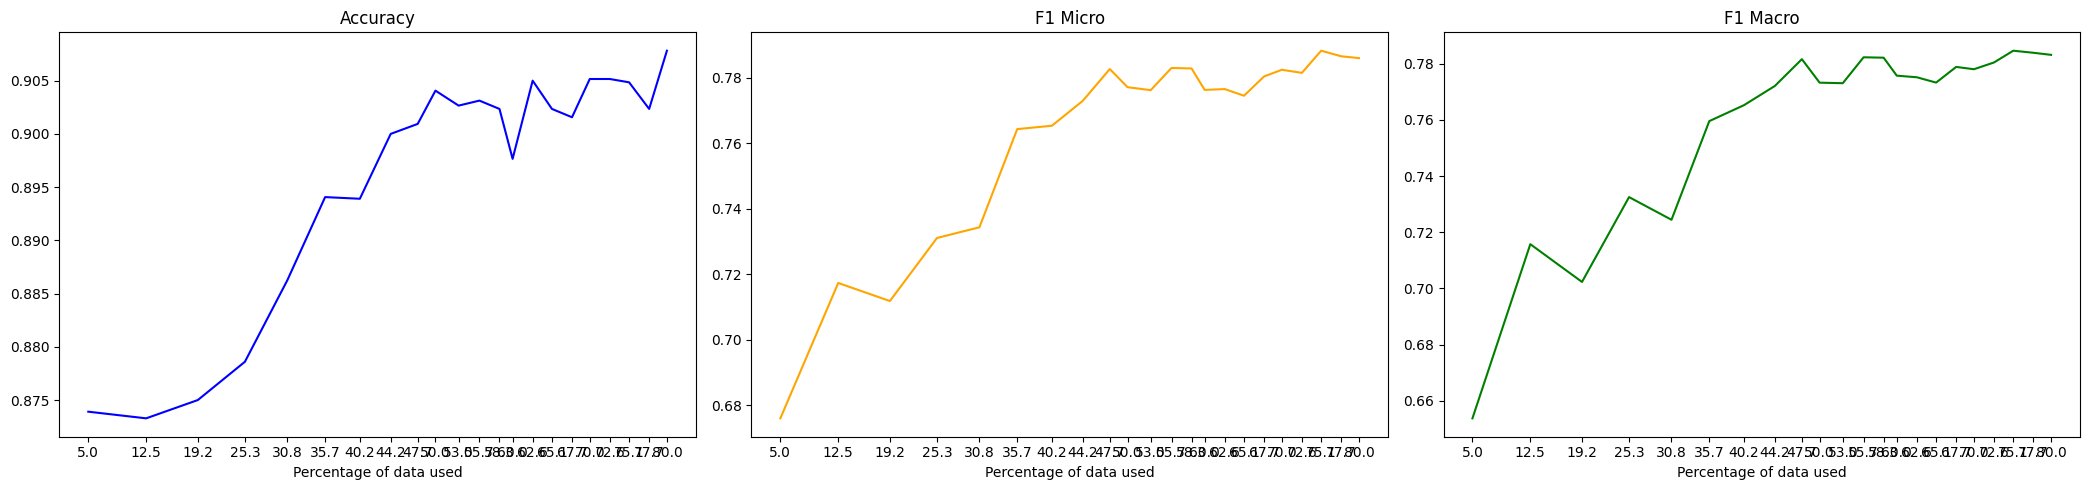

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.8033, F1 Micro: 0.1441, F1 Macro: 0.1113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.8278, F1 Micro: 0.3264, F1 Macro: 0.2306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.8564, F1 Micro: 0.6023, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.8639, F1 Micro: 0.6369, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.8661, F1 Micro: 0.644, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.8647, F1 Micro: 0.6636, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.8722, F1 Micro: 0.6955, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.8653, F1 Micro: 0.6735

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.8175, F1 Micro: 0.2522, F1 Macro: 0.1737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.8469, F1 Micro: 0.4842, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.872, F1 Micro: 0.6537, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.8753, F1 Micro: 0.6833, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.8822, F1 Micro: 0.7142, F1 Macro: 0.7096
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.8789, F1 Micro: 0.7066, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8789, F1 Micro: 0.7219, F1 Macro: 0.7253
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.8817, F1 Micro: 0.7195, F1 Macro: 0.7214
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3203, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.817, F1 Micro: 0.2489, F1 Macro: 0.172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.8581, F1 Micro: 0.5741, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.8744, F1 Micro: 0.6656, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.8863, F1 Micro: 0.7362, F1 Macro: 0.7299
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.8817, F1 Micro: 0.7339, F1 Macro: 0.7333
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8827, F1 Micro: 0.73, F1 Macro: 0.7291
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.8875, F1 Micro: 0.7345, F1 Macro: 0.7326
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.8875, F1 Micro: 0.7159, F1 Macro: 0.7098
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.8825, F1 Micro: 0.7152, F1 Macro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3069, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.8286, F1 Micro: 0.338, F1 Macro: 0.2321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.8711, F1 Micro: 0.647, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.8798, F1 Micro: 0.7221, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.8783, F1 Micro: 0.738, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.883, F1 Micro: 0.7416, F1 Macro: 0.7385
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.8909, F1 Micro: 0.7282, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.8856, F1 Micro: 0.7388, F1 Macro: 0.7322
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.8909, F1 Micro: 0.7368, F1 Macro: 0.7286
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.8883

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3329, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8541, F1 Micro: 0.5492, F1 Macro: 0.5266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.8753, F1 Micro: 0.731, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.8794, F1 Micro: 0.7349, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.8892, F1 Micro: 0.7465, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.8956, F1 Micro: 0.7567, F1 Macro: 0.757
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.8863, F1 Micro: 0.7451, F1 Macro: 0.7386
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.8922, F1 Micro: 0.7398, F1 Macro: 0.7272
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.8855, F1 Micro: 0.7377, F1 Macro: 0.7344
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3439, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.8677, F1 Micro: 0.6277, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.8917, F1 Micro: 0.7461, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.8922, F1 Micro: 0.7604, F1 Macro: 0.7582
Epoch 5/10, Train Loss: 0.1101, Accuracy: 0.8966, F1 Micro: 0.7479, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.8989, F1 Micro: 0.7675, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.8866, F1 Micro: 0.7507, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.8889, F1 Micro: 0.762, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.8922, F1 Micro: 0.7504, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8881, F1 Micro: 0.7524, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2616, Accuracy: 0.8742, F1 Micro: 0.6421, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.8858, F1 Micro: 0.7558, F1 Macro: 0.7577
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.8953, F1 Micro: 0.7555, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.8961, F1 Micro: 0.7711, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8922, F1 Micro: 0.7674, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8933, F1 Micro: 0.7563, F1 Macro: 0.7504
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.8886, F1 Micro: 0.764, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.8963, F1 Micro: 0.7598, F1 Macro: 0.7581
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.892, F1 Micro: 0.7475, F1 Macro: 0.7302

 Iteration 3432: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3683, Accuracy: 0.8216, F1 Micro: 0.3104, F1 Macro: 0.2806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.8833, F1 Micro: 0.6992, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.8952, F1 Micro: 0.7512, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.8953, F1 Micro: 0.756, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.8955, F1 Micro: 0.7691, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9002, F1 Micro: 0.7738, F1 Macro: 0.7717
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.8945, F1 Micro: 0.7705, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.8938, F1 Micro: 0.7614, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.8945, F1 Micro: 0.7695, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3624, Accuracy: 0.8481, F1 Micro: 0.5091, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.8872, F1 Micro: 0.7451, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.8944, F1 Micro: 0.7656, F1 Macro: 0.7565
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.885, F1 Micro: 0.7581, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9025, F1 Micro: 0.7724, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9017, F1 Micro: 0.7698, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.8998, F1 Micro: 0.7729, F1 Macro: 0.7705
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9002, F1 Micro: 0.7712, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.8975, F1 Micro: 0.775, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0293, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8422, F1 Micro: 0.4593, F1 Macro: 0.423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.8928, F1 Micro: 0.7474, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.8917, F1 Micro: 0.7686, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.8995, F1 Micro: 0.774, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.8939, F1 Micro: 0.774, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.8953, F1 Micro: 0.7741, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.8941, F1 Micro: 0.774, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9013, F1 Micro: 0.7787, F1 Macro: 0.7782
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.8959, F1 Micro: 0.7687, F1 Macro: 0.7702
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8761, F1 Micro: 0.6986, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.8906, F1 Micro: 0.7509, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.8916, F1 Micro: 0.7638, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.8969, F1 Micro: 0.7775, F1 Macro: 0.7768
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9048, F1 Micro: 0.775, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9013, F1 Micro: 0.7786, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9022, F1 Micro: 0.7826, F1 Macro: 0.7812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9067, F1 Micro: 0.785, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9038, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8728, F1 Micro: 0.6458, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.8914, F1 Micro: 0.7295, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.8984, F1 Micro: 0.769, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.8992, F1 Micro: 0.7736, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.8986, F1 Micro: 0.7746, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.8958, F1 Micro: 0.7753, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9056, F1 Micro: 0.7753, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9003, F1 Micro: 0.7765, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.903, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8759, F1 Micro: 0.6759, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8959, F1 Micro: 0.7446, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.8933, F1 Micro: 0.7723, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.8977, F1 Micro: 0.7726, F1 Macro: 0.7748
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9047, F1 Micro: 0.7691, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9056, F1 Micro: 0.7741, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.8986, F1 Micro: 0.7749, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9009, F1 Micro: 0.7791, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9022, F1 Micro: 0.7766, F1 Macro: 0.7737
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8736, F1 Micro: 0.6364, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.8928, F1 Micro: 0.7623, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9013, F1 Micro: 0.7671, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9031, F1 Micro: 0.7787, F1 Macro: 0.7763
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9072, F1 Micro: 0.7735, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9028, F1 Micro: 0.7761, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.8969, F1 Micro: 0.78, F1 Macro: 0.7801
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9053, F1 Micro: 0.7761, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9092, F1 Micro: 0.7843, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8814, F1 Micro: 0.6893, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.8981, F1 Micro: 0.7541, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9009, F1 Micro: 0.7652, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9022, F1 Micro: 0.7719, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9013, F1 Micro: 0.7746, F1 Macro: 0.7685
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.8984, F1 Micro: 0.765, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9013, F1 Micro: 0.7749, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9002, F1 Micro: 0.7602, F1 Macro: 0.7519
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8984, F1 Micro: 0.7721, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0335, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8822, F1 Micro: 0.6937, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8983, F1 Micro: 0.7484, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9006, F1 Micro: 0.7614, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9002, F1 Micro: 0.7696, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.8997, F1 Micro: 0.7738, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.8978, F1 Micro: 0.77, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9025, F1 Micro: 0.7757, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9034, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.369, Accuracy: 0.8845, F1 Micro: 0.7244, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8963, F1 Micro: 0.7704, F1 Macro: 0.7681
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9033, F1 Micro: 0.7691, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9077, F1 Micro: 0.7937, F1 Macro: 0.7923
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9038, F1 Micro: 0.7836, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9016, F1 Micro: 0.7697, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9011, F1 Micro: 0.7653, F1 Macro: 0.7539
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.903, F1 Micro: 0.7794, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9027, F1 Micro: 0.7765, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9031, F1 Micro: 0.7765, F1 Macro: 0.7714

 Iteration 5441: Accuracy: 0.9077, F1 Micro: 0.7937,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.89, F1 Micro: 0.7457, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.8997, F1 Micro: 0.7645, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9048, F1 Micro: 0.7797, F1 Macro: 0.772
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9067, F1 Micro: 0.7721, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9038, F1 Micro: 0.7825, F1 Macro: 0.7787
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.903, F1 Micro: 0.7641, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.8991, F1 Micro: 0.7725, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9016, F1 Micro: 0.7814, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9052, F1 Micro: 0.7808, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9, F1 Micro: 0.7792, F1 Macro: 0.7769

 Iteration 5641: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8884, F1 Micro: 0.7243, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.8994, F1 Micro: 0.7634, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9041, F1 Micro: 0.7799, F1 Macro: 0.7766
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.902, F1 Micro: 0.7763, F1 Macro: 0.7712
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9033, F1 Micro: 0.7701, F1 Macro: 0.7634
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9058, F1 Micro: 0.7795, F1 Macro: 0.7766
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9011, F1 Micro: 0.7769, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.8998, F1 Micro: 0.769, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9047, F1 Micro: 0.7741, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9041, F1 Micro: 0.7734, F1 Macro: 0.7695

 Iteration 5841: Accuracy: 0.9041, F1 Micro: 0.7799,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8906, F1 Micro: 0.7227, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9, F1 Micro: 0.7663, F1 Macro: 0.7533
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9031, F1 Micro: 0.7648, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9027, F1 Micro: 0.7835, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9059, F1 Micro: 0.787, F1 Macro: 0.7834
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9017, F1 Micro: 0.753, F1 Macro: 0.7431
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9047, F1 Micro: 0.7767, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9033, F1 Micro: 0.7809, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9045, F1 Micro: 0.7716, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9006, F1 Micro: 0.7781, F1 Macro: 0.7767

 Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.8905, F1 Micro: 0.7311, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.9023, F1 Micro: 0.7642, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9039, F1 Micro: 0.7879, F1 Macro: 0.7867
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.905, F1 Micro: 0.7792, F1 Macro: 0.7703
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9048, F1 Micro: 0.7704, F1 Macro: 0.763
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.9005, F1 Micro: 0.7752, F1 Macro: 0.771
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9008, F1 Micro: 0.7829, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.8998, F1 Micro: 0.7744, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9033, F1 Micro: 0.7784, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9047, F1 Micro: 0.7809, F1 Macro: 0.7769

 Iteration 6218: Accuracy: 0.9039, F1 Micro: 0.7879, F

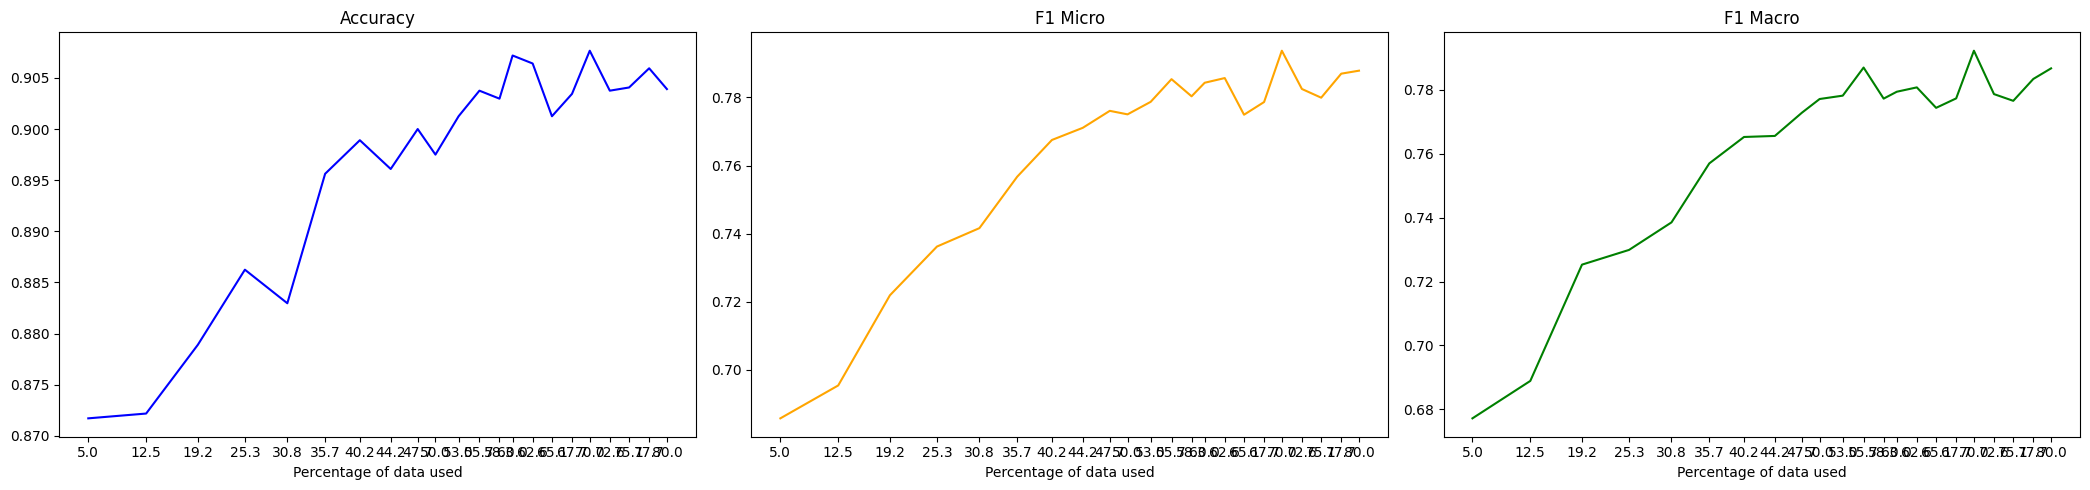

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.306, Accuracy: 0.7981, F1 Micro: 0.1015, F1 Macro: 0.0824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2437, Accuracy: 0.8275, F1 Micro: 0.3341, F1 Macro: 0.2298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.8544, F1 Micro: 0.5701, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.867, F1 Micro: 0.6168, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.8492, F1 Micro: 0.701, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.8736, F1 Micro: 0.7083, F1 Macro: 0.6989
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.8675, F1 Micro: 0.6695, F1 Macro: 0.65
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.8755, F1 Micro: 0.6964, F1 Macro: 0.6896
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.8017, F1 Micro: 0.1314, F1 Macro: 0.103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.8342, F1 Micro: 0.3906, F1 Macro: 0.2648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.8589, F1 Micro: 0.6762, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.8636, F1 Micro: 0.6799, F1 Macro: 0.6775
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.865, F1 Micro: 0.6317, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.8709, F1 Micro: 0.6943, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8698, F1 Micro: 0.6945, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8719, F1 Micro: 0.6712, F1 Macro: 0.658
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3222, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.8037, F1 Micro: 0.1479, F1 Macro: 0.1138
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.865, F1 Micro: 0.6348, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.8763, F1 Micro: 0.6909, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.8725, F1 Micro: 0.6982, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.8803, F1 Micro: 0.7184, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.8756, F1 Micro: 0.7187, F1 Macro: 0.715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.8778, F1 Micro: 0.7326, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0347, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.8202, F1 Micro: 0.2784, F1 Macro: 0.196
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.8731, F1 Micro: 0.6821, F1 Macro: 0.6842
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.8708, F1 Micro: 0.6201, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.8861, F1 Micro: 0.7392, F1 Macro: 0.7351
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.8712, F1 Micro: 0.7312, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.8894, F1 Micro: 0.7401, F1 Macro: 0.7367
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8872, F1 Micro: 0.7171, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8884, F1 Micro: 0.7392, F1 Macro: 0.7389
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.882, F1 Micro: 0.7374, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3091, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.8423, F1 Micro: 0.4636, F1 Macro: 0.3979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.8734, F1 Micro: 0.6686, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.8822, F1 Micro: 0.7321, F1 Macro: 0.7326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.8866, F1 Micro: 0.7502, F1 Macro: 0.7458
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.8856, F1 Micro: 0.7354, F1 Macro: 0.7305
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.8755, F1 Micro: 0.7433, F1 Macro: 0.7463
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.8833, F1 Micro: 0.7407, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.8895, F1 Micro: 0.7518, F1 Macro: 0.7527
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8712, F1 Micro: 0.6414, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.8859, F1 Micro: 0.7126, F1 Macro: 0.7051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.8941, F1 Micro: 0.7483, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.8916, F1 Micro: 0.7579, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.0859, Accuracy: 0.8905, F1 Micro: 0.7468, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8938, F1 Micro: 0.7472, F1 Macro: 0.7351
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.8869, F1 Micro: 0.7497, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.8919, F1 Micro: 0.7645, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3542, Accuracy: 0.8047, F1 Micro: 0.1565, F1 Macro: 0.1206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.8661, F1 Micro: 0.5948, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.8881, F1 Micro: 0.7238, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.8947, F1 Micro: 0.7601, F1 Macro: 0.7596
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.8936, F1 Micro: 0.7553, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.8894, F1 Micro: 0.7676, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8939, F1 Micro: 0.7627, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.8959, F1 Micro: 0.77, F1 Macro: 0.7708
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.8945, F1 Micro: 0.7557, F1 Macro: 0.7489
Epoch 10/10, Train Loss: 0.028, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.8205, F1 Micro: 0.3148, F1 Macro: 0.2878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.8772, F1 Micro: 0.731, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.893, F1 Micro: 0.7611, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.8961, F1 Micro: 0.7633, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.8973, F1 Micro: 0.7661, F1 Macro: 0.7607
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.8952, F1 Micro: 0.7646, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.8925, F1 Micro: 0.7669, F1 Macro: 0.7695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.8953, F1 Micro: 0.7741, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8925, F1 Micro: 0.7641, F1 Macro: 0.7618
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8436, F1 Micro: 0.4906, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.8712, F1 Micro: 0.6213, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.8953, F1 Micro: 0.7609, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.897, F1 Micro: 0.7692, F1 Macro: 0.7697
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9002, F1 Micro: 0.7655, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9013, F1 Micro: 0.7723, F1 Macro: 0.7751
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.8992, F1 Micro: 0.7691, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9002, F1 Micro: 0.7732, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.8955, F1 Micro: 0.7719, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0317, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.847, F1 Micro: 0.4866, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8839, F1 Micro: 0.6986, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.8931, F1 Micro: 0.7432, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.8922, F1 Micro: 0.7643, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9008, F1 Micro: 0.7652, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.8966, F1 Micro: 0.7687, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.8978, F1 Micro: 0.7668, F1 Macro: 0.7616
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.8972, F1 Micro: 0.7597, F1 Macro: 0.7519
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.8936, F1 Micro: 0.7692, F1 Macro: 0.7681
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3787, Accuracy: 0.8731, F1 Micro: 0.6482, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.8847, F1 Micro: 0.7366, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.8977, F1 Micro: 0.7584, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.8952, F1 Micro: 0.7623, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.8967, F1 Micro: 0.7745, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.8956, F1 Micro: 0.7723, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.8997, F1 Micro: 0.7696, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.8934, F1 Micro: 0.764, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.895, F1 Micro: 0.7659, F1 Macro: 0.7674
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.903, F1 Micro: 0.7734, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8581, F1 Micro: 0.5622, F1 Macro: 0.5061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.8712, F1 Micro: 0.6146, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.8983, F1 Micro: 0.771, F1 Macro: 0.7719
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9013, F1 Micro: 0.7597, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.8998, F1 Micro: 0.7725, F1 Macro: 0.7688
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.8988, F1 Micro: 0.7564, F1 Macro: 0.7488
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.8952, F1 Micro: 0.7714, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9006, F1 Micro: 0.7722, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9011, F1 Micro: 0.7773, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9014, F1 Micro: 0.7763, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8791, F1 Micro: 0.7014, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8891, F1 Micro: 0.7174, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2182, Accuracy: 0.895, F1 Micro: 0.7569, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9002, F1 Micro: 0.7788, F1 Macro: 0.7784
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9003, F1 Micro: 0.7635, F1 Macro: 0.7613
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.903, F1 Micro: 0.7679, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9009, F1 Micro: 0.7768, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9009, F1 Micro: 0.7783, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9039, F1 Micro: 0.7761, F1 Macro: 0.7741

 Iteration 4663: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8823, F1 Micro: 0.7191, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.8948, F1 Micro: 0.7469, F1 Macro: 0.734
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.8941, F1 Micro: 0.7244, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9019, F1 Micro: 0.7759, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.903, F1 Micro: 0.7777, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9002, F1 Micro: 0.7674, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9028, F1 Micro: 0.7688, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9028, F1 Micro: 0.7767, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.8997, F1 Micro: 0.7704, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9008, F1 Micro: 0.7757, F1 Macro: 0.7752

 Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8695, F1 Micro: 0.6297, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.895, F1 Micro: 0.7584, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.8995, F1 Micro: 0.7693, F1 Macro: 0.766
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.897, F1 Micro: 0.7327, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9038, F1 Micro: 0.7698, F1 Macro: 0.7705
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9031, F1 Micro: 0.7685, F1 Macro: 0.7615
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9013, F1 Micro: 0.7668, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9003, F1 Micro: 0.7725, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9003, F1 Micro: 0.7529, F1 Macro: 0.7447
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9005, F1 Micro: 0.761, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8733, F1 Micro: 0.6545, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8994, F1 Micro: 0.7602, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.8977, F1 Micro: 0.7791, F1 Macro: 0.7756
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9031, F1 Micro: 0.7724, F1 Macro: 0.7656
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.8975, F1 Micro: 0.7615, F1 Macro: 0.7437
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.8978, F1 Micro: 0.7581, F1 Macro: 0.7518
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.8972, F1 Micro: 0.7621, F1 Macro: 0.7543
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.8997, F1 Micro: 0.7557, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9023, F1 Micro: 0.7667, F1 Macro: 0.7592
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9016, F1 Micro: 0.7724, F1 Macro: 0.7671

 Iteration 5263: Accuracy: 0.8977, F1 Micro: 0.77

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.8884, F1 Micro: 0.7336, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.8977, F1 Micro: 0.7733, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9067, F1 Micro: 0.779, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9034, F1 Micro: 0.7838, F1 Macro: 0.783
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9023, F1 Micro: 0.7808, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.8972, F1 Micro: 0.7747, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.8992, F1 Micro: 0.7734, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9009, F1 Micro: 0.7741, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9014, F1 Micro: 0.7731, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.8992, F1 Micro: 0.7744, F1 Macro: 0.7714

 Iteration 5441: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.8914, F1 Micro: 0.738, F1 Macro: 0.7232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.9, F1 Micro: 0.7685, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9059, F1 Micro: 0.7806, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9039, F1 Micro: 0.7761, F1 Macro: 0.7703
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9031, F1 Micro: 0.7741, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9077, F1 Micro: 0.7807, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9039, F1 Micro: 0.7725, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9055, F1 Micro: 0.7839, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9022, F1 Micro: 0.784, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.0338, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8856, F1 Micro: 0.7497, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8977, F1 Micro: 0.767, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9047, F1 Micro: 0.7767, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9041, F1 Micro: 0.7852, F1 Macro: 0.7833
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9028, F1 Micro: 0.7802, F1 Macro: 0.7746
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7599
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9011, F1 Micro: 0.7706, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9023, F1 Micro: 0.7757, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9013, F1 Micro: 0.7795, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9055, F1 Micro: 0.7785, F1 Macro: 0.7768

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.8928, F1 Micro: 0.7403, F1 Macro: 0.732
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.8919, F1 Micro: 0.7017, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9028, F1 Micro: 0.7595, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9044, F1 Micro: 0.7879, F1 Macro: 0.7846
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.768
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9003, F1 Micro: 0.775, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9017, F1 Micro: 0.7775, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9025, F1 Micro: 0.7842, F1 Macro: 0.7827
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.8994, F1 Micro: 0.7798, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9006, F1 Micro: 0.773, F1 Macro: 0.7709

 Iteration 6041: Accuracy: 0.9044, F1 Micro: 0.7879, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.362, Accuracy: 0.8859, F1 Micro: 0.711, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.8997, F1 Micro: 0.7494, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.8953, F1 Micro: 0.779, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.8995, F1 Micro: 0.7831, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9047, F1 Micro: 0.7826, F1 Macro: 0.7773
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9059, F1 Micro: 0.7782, F1 Macro: 0.7737
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9022, F1 Micro: 0.7745, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.8998, F1 Micro: 0.7832, F1 Macro: 0.7829
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9002, F1 Micro: 0.7696, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9016, F1 Micro: 0.7665, F1 M

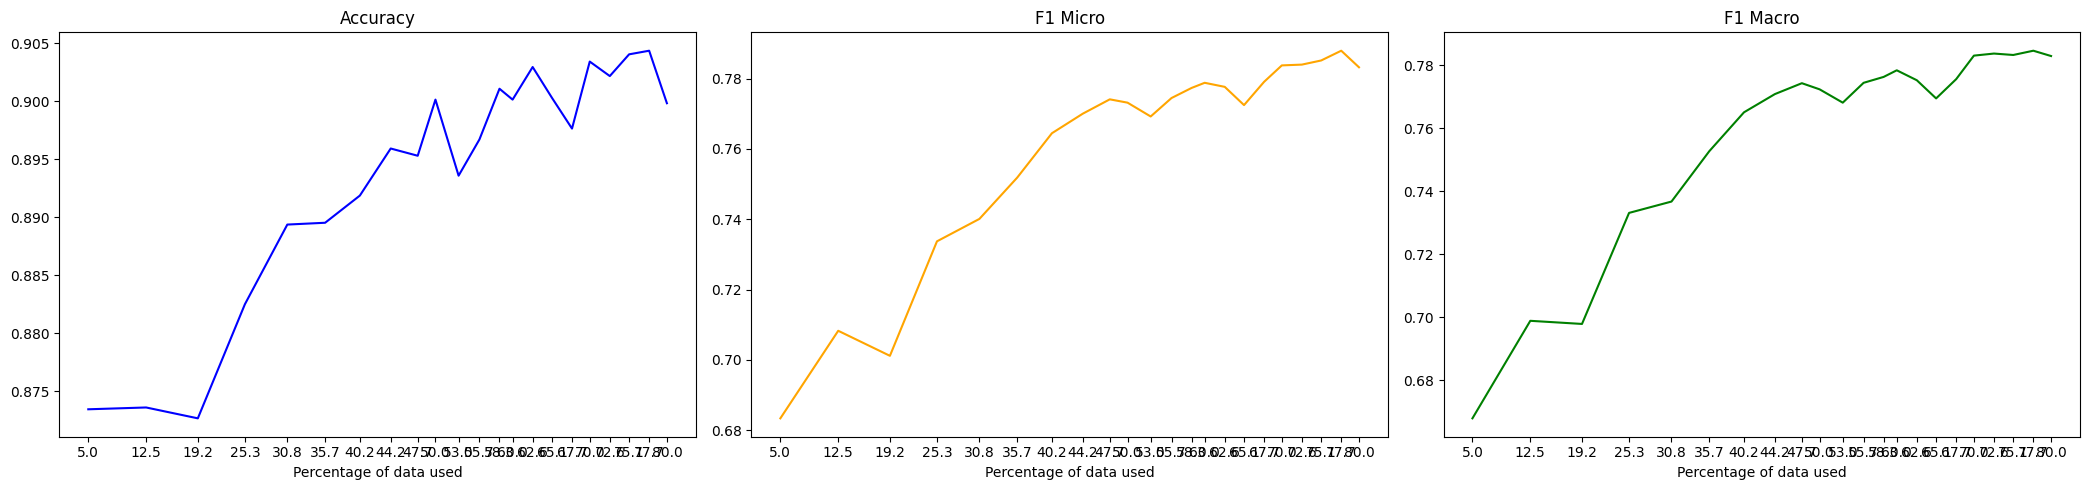

In [22]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4191, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2821, Accuracy: 0.7955, F1 Micro: 0.1291, F1 Macro: 0.0997
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.8423, F1 Micro: 0.4748, F1 Macro: 0.3275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.8561, F1 Micro: 0.5853, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.8681, F1 Micro: 0.6629, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.8697, F1 Micro: 0.6902, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8712, F1 Micro: 0.7032, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.8658, F1 Micro: 0.7047, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.8717, F1 Micro: 0.69

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.8039, F1 Micro: 0.2181, F1 Macro: 0.1646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.8533, F1 Micro: 0.5408, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.8602, F1 Micro: 0.5839, F1 Macro: 0.5248
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.8753, F1 Micro: 0.6888, F1 Macro: 0.6694
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8731, F1 Micro: 0.6539, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.8838, F1 Micro: 0.723, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.8861, F1 Micro: 0.7414, F1 Macro: 0.7371
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.8864, F1 Micro: 0.7332, F1 Macro: 0.7221
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3045, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.8148, F1 Micro: 0.3673, F1 Macro: 0.2627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.8547, F1 Micro: 0.5369, F1 Macro: 0.424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.872, F1 Micro: 0.7133, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.8848, F1 Micro: 0.7281, F1 Macro: 0.7129
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.8847, F1 Micro: 0.7183, F1 Macro: 0.7098
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.8861, F1 Micro: 0.7092, F1 Macro: 0.7005
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.8858, F1 Micro: 0.7187, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8848, F1 Micro: 0.7382, F1 Macro: 0.7354
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3051, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.8431, F1 Micro: 0.5178, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.8728, F1 Micro: 0.6482, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.8845, F1 Micro: 0.7108, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.8872, F1 Micro: 0.7456, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.8875, F1 Micro: 0.7564, F1 Macro: 0.7573
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.8906, F1 Micro: 0.7477, F1 Macro: 0.7389
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.8933, F1 Micro: 0.7481, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.8933, F1 Micro: 0.7574, F1 Macro: 0.7566
Epoch 10/10, Trai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.8522, F1 Micro: 0.5508, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.8803, F1 Micro: 0.7282, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.8897, F1 Micro: 0.7421, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.8863, F1 Micro: 0.7578, F1 Macro: 0.7577
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.8852, F1 Micro: 0.7531, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.8867, F1 Micro: 0.7555, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8909, F1 Micro: 0.765, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.8931, F1 Micro: 0.7576, F1 Macro: 0.7583
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.7925, F1 Micro: 0.0541, F1 Macro: 0.035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8567, F1 Micro: 0.6733, F1 Macro: 0.668
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.8773, F1 Micro: 0.6559, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.8881, F1 Micro: 0.7278, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.883, F1 Micro: 0.7606, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.8923, F1 Micro: 0.7547, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.8909, F1 Micro: 0.7566, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.8917, F1 Micro: 0.76, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.895, F1 Micro: 0.7684, F1 Macro: 0.7685
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.8927, F1 Micro: 0.7661, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3437, Accuracy: 0.8223, F1 Micro: 0.3037, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.8739, F1 Micro: 0.6431, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.8897, F1 Micro: 0.7374, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.8953, F1 Micro: 0.7639, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.8956, F1 Micro: 0.769, F1 Macro: 0.7694
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.8967, F1 Micro: 0.767, F1 Macro: 0.7652
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8927, F1 Micro: 0.7662, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.8961, F1 Micro: 0.7689, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.8938, F1 Micro: 0.7707, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0267, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8316, F1 Micro: 0.3951, F1 Macro: 0.3589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.88, F1 Micro: 0.6858, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.8952, F1 Micro: 0.7559, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.8813, F1 Micro: 0.7581, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.8961, F1 Micro: 0.7676, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.8967, F1 Micro: 0.7734, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.8942, F1 Micro: 0.7701, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.8906, F1 Micro: 0.7659, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8964, F1 Micro: 0.763, F1 Macro: 0.7611
Epoch 10/10, Train Loss: 0.0302, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8313, F1 Micro: 0.3699, F1 Macro: 0.3211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2565, Accuracy: 0.8877, F1 Micro: 0.7411, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.895, F1 Micro: 0.7433, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.8983, F1 Micro: 0.7742, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.8952, F1 Micro: 0.7757, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.8978, F1 Micro: 0.7687, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8978, F1 Micro: 0.7726, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.8989, F1 Micro: 0.7782, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.8995, F1 Micro: 0.7695, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0286, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8608, F1 Micro: 0.5639, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8913, F1 Micro: 0.736, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.897, F1 Micro: 0.7522, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.893, F1 Micro: 0.7739, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.897, F1 Micro: 0.7744, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.8997, F1 Micro: 0.7739, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.8969, F1 Micro: 0.7663, F1 Macro: 0.765
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.8994, F1 Micro: 0.77, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.8958, F1 Micro: 0.7709, F1 Macro: 0.7677
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.8975, F1 Micro: 0.7701, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8716, F1 Micro: 0.6382, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.8916, F1 Micro: 0.7316, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.8958, F1 Micro: 0.7683, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9019, F1 Micro: 0.7734, F1 Macro: 0.766
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.8997, F1 Micro: 0.7723, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9025, F1 Micro: 0.7684, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9023, F1 Micro: 0.7765, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.895, F1 Micro: 0.7778, F1 Macro: 0.7804
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7719
Epoch 10/10, Train Loss: 0.0315, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8541, F1 Micro: 0.627, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.8953, F1 Micro: 0.7565, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.897, F1 Micro: 0.7618, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.8998, F1 Micro: 0.7752, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9038, F1 Micro: 0.7789, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.8981, F1 Micro: 0.773, F1 Macro: 0.7711
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.8989, F1 Micro: 0.7765, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9045, F1 Micro: 0.7834, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9016, F1 Micro: 0.7783, F1 Macro: 0.7754
Epoch 10/10, Train Loss: 0.0305, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.8708, F1 Micro: 0.6421, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8877, F1 Micro: 0.7547, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9025, F1 Micro: 0.7613, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9022, F1 Micro: 0.7709, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.8956, F1 Micro: 0.7775, F1 Macro: 0.7763
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9044, F1 Micro: 0.7824, F1 Macro: 0.7774
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9014, F1 Micro: 0.7738, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9023, F1 Micro: 0.7741, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8819, F1 Micro: 0.7125, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.8955, F1 Micro: 0.7442, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9009, F1 Micro: 0.7597, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.8988, F1 Micro: 0.7657, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.8923, F1 Micro: 0.7719, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.8989, F1 Micro: 0.7805, F1 Macro: 0.7814
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9009, F1 Micro: 0.7758, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9041, F1 Micro: 0.7799, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9003, F1 Micro: 0.7821, F1 Macro: 0.7811
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8811, F1 Micro: 0.7178, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.8998, F1 Micro: 0.7658, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9036, F1 Micro: 0.7792, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.8983, F1 Micro: 0.78, F1 Macro: 0.7796
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.8989, F1 Micro: 0.778, F1 Macro: 0.7782
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9005, F1 Micro: 0.7752, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9006, F1 Micro: 0.7706, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9022, F1 Micro: 0.7788, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9022, F1 Micro: 0.778, F1 Macro: 0.7738
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.902, F1 Micro: 0.7798, F1 Macro: 0.7764

 Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8794, F1 Micro: 0.734, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.8966, F1 Micro: 0.7627, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9002, F1 Micro: 0.7814, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9039, F1 Micro: 0.7655, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9061, F1 Micro: 0.7819, F1 Macro: 0.7744
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9056, F1 Micro: 0.7788, F1 Macro: 0.7756
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9002, F1 Micro: 0.778, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9031, F1 Micro: 0.7744, F1 Macro: 0.7681
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9056, F1 Micro: 0.7796, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9052, F1 Micro: 0.7785, F1 Macro: 0.7755

 Iteration 5263: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8825, F1 Micro: 0.7345, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.8997, F1 Micro: 0.7583, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.902, F1 Micro: 0.7732, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9053, F1 Micro: 0.7777, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9042, F1 Micro: 0.7816, F1 Macro: 0.7755
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.8994, F1 Micro: 0.7739, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9055, F1 Micro: 0.7742, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9027, F1 Micro: 0.7607, F1 Macro: 0.7553
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9031, F1 Micro: 0.7762, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9003, F1 Micro: 0.7752, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.8886, F1 Micro: 0.7337, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.8994, F1 Micro: 0.743, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9047, F1 Micro: 0.7766, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9045, F1 Micro: 0.7785, F1 Macro: 0.7754
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9036, F1 Micro: 0.7697, F1 Macro: 0.7636
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9044, F1 Micro: 0.7737, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9075, F1 Micro: 0.7825, F1 Macro: 0.778
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9033, F1 Micro: 0.7753, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9034, F1 Micro: 0.7663, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9005, F1 Micro: 0.7693, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8875, F1 Micro: 0.7315, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.8964, F1 Micro: 0.749, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9027, F1 Micro: 0.7675, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9045, F1 Micro: 0.759, F1 Macro: 0.741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9056, F1 Micro: 0.7837, F1 Macro: 0.7804
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9044, F1 Micro: 0.7797, F1 Macro: 0.7731
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9008, F1 Micro: 0.779, F1 Macro: 0.7771
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.8984, F1 Micro: 0.7817, F1 Macro: 0.7814
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9034, F1 Micro: 0.7801, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9036, F1 Micro: 0.763, F1 Macro: 0.755

 Iteration 5841: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8884, F1 Micro: 0.73, F1 Macro: 0.724
Epoch 2/10, Train Loss: 0.2366, Accuracy: 0.8945, F1 Micro: 0.7257, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9062, F1 Micro: 0.7698, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9053, F1 Micro: 0.7817, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9064, F1 Micro: 0.7832, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9034, F1 Micro: 0.7787, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9064, F1 Micro: 0.7816, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9041, F1 Micro: 0.7676, F1 Macro: 0.7607
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9023, F1 Micro: 0.7658, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9039, F1 Micro: 0.776, F1 Macro: 0.7748

 Iteration 6041: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3583, Accuracy: 0.8894, F1 Micro: 0.7567, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.9, F1 Micro: 0.7699, F1 Macro: 0.7669
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9014, F1 Micro: 0.7385, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.8978, F1 Micro: 0.7824, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9042, F1 Micro: 0.7791, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9034, F1 Micro: 0.7816, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9011, F1 Micro: 0.7833, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9045, F1 Micro: 0.7741, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9013, F1 Micro: 0.7698, F1 Macro: 0.7639
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9062, F1 Micro: 0.7784, F1 Macro: 0.773

 Iteration 6218: Accura

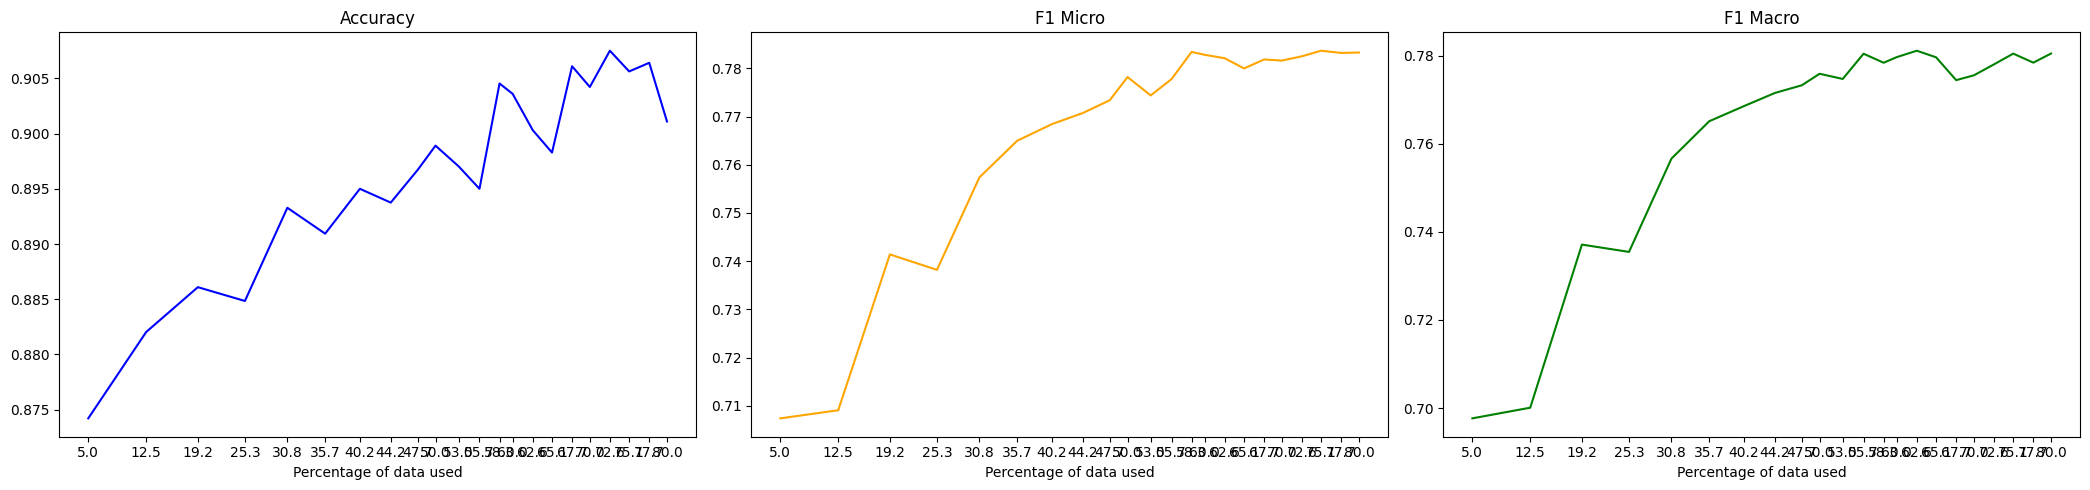

In [23]:
active_learning(seeds[4], 4)